<a href="https://colab.research.google.com/github/AleksandraBelousova/Feature-Selection-Prediction-with-ML-/blob/main/Feature_Selection_%26_Prediction_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.8 MB/s eta 0:00:00


In [3]:
!gdown "https://drive.google.com/uc?export=download&id=1Trwt8zbiOuqDSRG5AaAJYKsoGs020uv_" -O actual.csv
!gdown "https://drive.google.com/uc?export=download&id=1vtkwJoQEv5qrk7yiODeGNnOrPpM-iXBa" -O data_set_ALL_AML_train.csv
!gdown "https://drive.google.com/uc?export=download&id=1DPBRFS8D0MitjM9lUj_bc1_YIddQR67Z" -O data_set_ALL_AML_independent.csv

Downloading...
From: https://drive.google.com/uc?export=download&id=1Trwt8zbiOuqDSRG5AaAJYKsoGs020uv_
To: /content/actual.csv
100% 511/511 [00:00<00:00, 1.62MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1vtkwJoQEv5qrk7yiODeGNnOrPpM-iXBa
To: /content/data_set_ALL_AML_train.csv
100% 2.04M/2.04M [00:00<00:00, 31.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1DPBRFS8D0MitjM9lUj_bc1_YIddQR67Z
To: /content/data_set_ALL_AML_independent.csv
100% 1.86M/1.86M [00:00<00:00, 20.2MB/s]


In [5]:
for df, name in zip([actual_df, train_df, test_df], ['Actual', 'Train', 'Test']):
    print(f"{name} DataFrame Info:")
    df.info()
    print("\n")

Actual DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   patient  72 non-null     int64 
 1   cancer   72 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gene Description       7129 non-null   object
 1   Gene Accession Number  7129 non-null   object
 2   1                      7129 non-null   int64 
 3   call                   7129 non-null   object
 4   2                      7129 non-null   int64 
 5   call.1                 7129 non-null   object
 6   3                      7129 non-null   int64 
 7   call.2                 7129 non-null   object
 8   4                      7129 non

In [6]:
train_data = pd.read_csv('data_set_ALL_AML_train.csv')
test_data = pd.read_csv('data_set_ALL_AML_independent.csv')
actual_data = pd.read_csv('actual.csv')

def get_meta_columns(df):
    return ['Gene Description', 'Gene Accession Number'] + [col for col in df.columns if 'call' in col]

# Clean and transpose train and test datasets
def clean_and_transpose(df, meta_cols):
    df_clean = df.drop(columns=meta_cols).transpose()
    df_clean.columns = df_clean.iloc[0]
    df_clean = df_clean.drop(df_clean.index[0])
    df_clean.index = df_clean.index.astype(int)
    return df_clean.apply(pd.to_numeric, errors='coerce')

train_data_clean = clean_and_transpose(train_data, get_meta_columns(train_data))
test_data_clean = clean_and_transpose(test_data, get_meta_columns(test_data))

train_data_clean['patient'] = train_data_clean.index
train_data_merged = pd.merge(train_data_clean, actual_data, on='patient').drop(columns='patient')

In [7]:
label_encoder = LabelEncoder()
train_data_merged['cancer_encoded'] = label_encoder.fit_transform(train_data_merged['cancer'])

X = train_data_merged.drop(columns=['cancer', 'cancer_encoded'])
y = train_data_merged['cancer_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

Confusion Matrix:
 [[5 0]
 [1 2]]


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gbc = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print(f"Accuracy with Gradient Boosting: {accuracy_score(y_val, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy with Gradient Boosting: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.33      0.50         3

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



In [9]:
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensionality while preserving 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test = test_data_clean
X_test_pca = pca.transform(X_test)
best_model.fit(X_train_pca, y_train)
y_pred_pca = best_model.predict(X_val_pca)
print(f"Accuracy with PCA and Gradient Boosting: {accuracy_score(y_val, y_pred_pca):.2f}")
print("Classification Report with PCA:\n", classification_report(y_val, y_pred_pca))
test_predictions_pca = best_model.predict(X_test_pca)
print("Test Predictions with PCA:\n", label_encoder.inverse_transform(test_predictions_pca))

Accuracy with PCA and Gradient Boosting: 0.88
Classification Report with PCA:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

Test Predictions with PCA:
 ['ALL' 'ALL' 'ALL' 'ALL' 'ALL' 'ALL' 'AML' 'ALL' 'ALL' 'AML' 'ALL' 'ALL'
 'ALL' 'ALL' 'ALL' 'AML' 'AML' 'AML' 'AML' 'AML' 'AML' 'AML' 'AML' 'ALL'
 'AML' 'AML' 'AML' 'AML' 'AML' 'ALL' 'AML' 'ALL' 'AML']


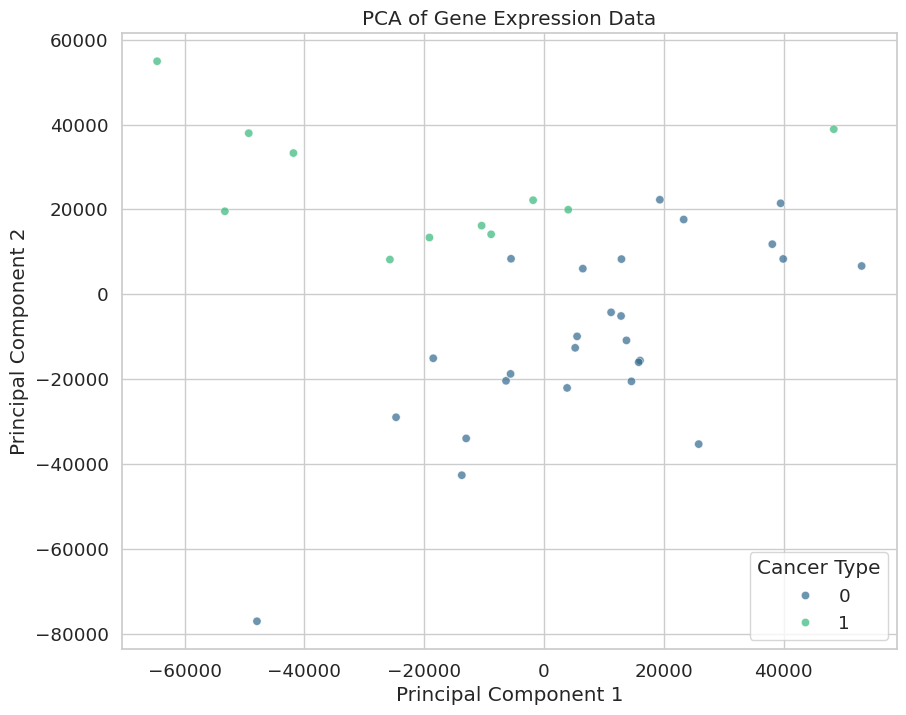

In [10]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Label'] = y

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cancer Type')
plt.show()

upscale

In [13]:
!pip install lasso

In [15]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
lasso = LassoCV(cv=5, random_state=42)

In [16]:
lasso.fit(X_train, y_train)
selected_features_lasso = X_train.columns[(lasso.coef_ != 0)]
print("LASSO: ", selected_features_lasso)

LASSO:  Index([15091,  8529, 18727,  7819,  4801,  2654, 15962,   741,  3221,  3079,
       14223,    56,   670,  1489,   782,  1298,  2534,   749,   177,  3989,
        5017,  3215, 14552,  9144, 31086, 17602, 16528, 21909,   153,  8418,
        8421, 14339, 13537],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e-03, tolerance: 5.793e-04
  model = cd_fast.enet_coordinate_descent(


In [17]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10, step=1)

In [29]:
from sklearn.linear_model import LogisticRegression
rfe = RFE(estimator=LogisticRegression(),n_features_to_select=10)

In [31]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

selected_features_rfe = X_train.columns[rfe.support_]
print("RFE Selected Features:", selected_features_rfe)

X_train_selected = X_train[selected_features_rfe]
X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train_sel, y_train_sel)
y_pred = model.predict(X_val_sel)

print(f"Accuracy: {accuracy_score(y_val_sel, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_val_sel, y_pred))

RFE Selected Features: Index([2654, 56, 303, 15119, 4243, 177, 7546, 14552, 333, 15009], dtype='object')
Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

